# State Farm Data Science Classification Exercise

Brennan Clinch

## Import libraries and read in the data

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE

from sklearn.utils import resample
 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, precision_recall_curve, roc_curve

In [2]:
# Read in data set
df = pd.read_csv("C://Users//JCCLI//Downloads//DS_Work_Sample_Data.csv", index_col = 0)

In [3]:
# Check metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60000 entries, 0 to 59999
Data columns (total 55 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   plcy_id             60000 non-null  int64  
 1   sample              60000 non-null  object 
 2   curnt_bi_low        60000 non-null  int64  
 3   curnt_bi_upp        60000 non-null  int64  
 4   curnt_pd_lmt        60000 non-null  int64  
 5   curnt_coll_ded      45384 non-null  float64
 6   curnt_comp_ded      41436 non-null  float64
 7   hh_veh_cnt          60000 non-null  int64  
 8   hh_cnt_auto         60000 non-null  int64  
 9   hh_cnt_mtrcyc       60000 non-null  int64  
 10  hh_veh_w_coll_cnt   60000 non-null  int64  
 11  hh_veh_w_comp_cnt   60000 non-null  int64  
 12  hh_veh_lien_cnt     52254 non-null  float64
 13  hh_veh_lease_cnt    52254 non-null  float64
 14  hh_veh_own_cnt      52254 non-null  float64
 15  veh_ownership       53150 non-null  object 
 16  annual_mi

In [4]:
# Preview Data 
df.head()

,plcy_id,sample,curnt_bi_low,curnt_bi_upp,curnt_pd_lmt,curnt_coll_ded,curnt_comp_ded,hh_veh_cnt,hh_cnt_auto,hh_cnt_mtrcyc,...,hh_atf_clm_cnt_py2,hh_atf_clm_cnt_py3,hh_atf_clm_cnt_py4,hh_atf_clm_cnt_py5,hh_naf_clm_cnt_py1,hh_naf_clm_cnt_py2,hh_naf_clm_cnt_py3,hh_naf_clm_cnt_py4,hh_naf_clm_cnt_py5,future_clm_ind
0,1,Train,100000,300000,20000,250.0,250.0,2,2,0,...,0,0,0,0,1,1,1,1,1,0.0
1,2,Train,50000,100000,20000,1000.0,1000.0,1,1,0,...,0,0,0,1,0,0,0,0,0,0.0
2,3,Train,25000,50000,25000,NaN,NaN,1,1,0,...,0,0,0,0,0,0,0,0,0,0.0
3,4,Train,25000,50000,25000,NaN,NaN,1,1,0,...,1,1,0,0,0,0,0,0,0,0.0
4,5,Train,25000,50000,25000,500.0,NaN,1,1,0,...,0,0,0,0,0,0,0,0,0,0.0


## Data Exploration

**Subset training and test datasets**

We will have 2 datasets for this model, the first one is our training data which will be used for our data exploration and model development. The second one is a holdout (or test) set which will be used to evaluate our model's performance on unseen data. It should be noted that any data cleaning and transformations we make (such as log or square root transform along with encoding our categorical features) on variables in the training set should also be applied in the test set.

In [5]:
# Subset training and holdout data
# Training
df_train = df.loc[0:39999]

#Holdout
df_holdout = df.loc[40000:59999]

**Data visualization of our features and target variable**

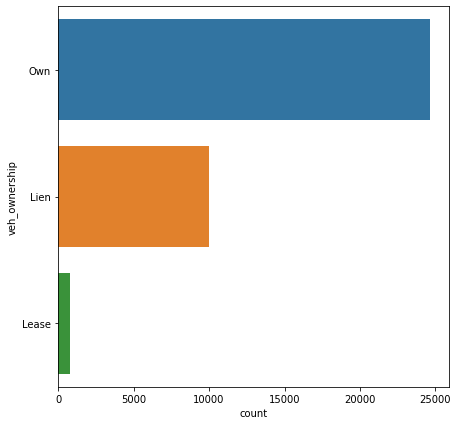

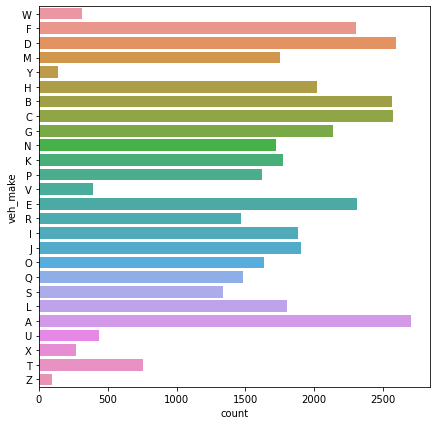

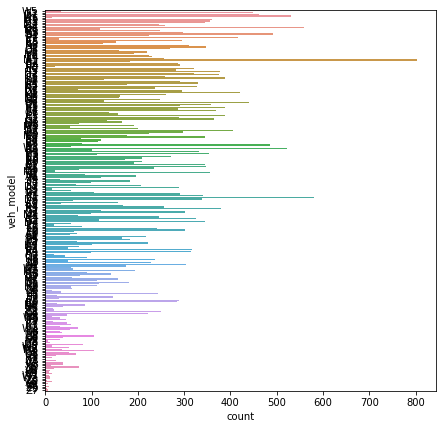

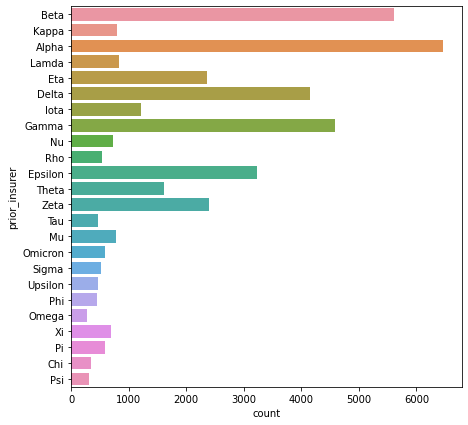

In [106]:
# Visualizing categorical features.
cat = ['veh_ownership', 'veh_make','veh_model','prior_insurer']
for i in range(4):
    plt.figure(figsize=(7,7))
    pl = sns.countplot(data=df_train,y=cat[i])
    plt.show()

**Observations**

- Most holders have a vehicle on the policy that is owned outright.

- Alpha is the most frequent prior insurer.

- A and D are the most popular vehicle makes.

([<matplotlib.patches.Wedge at 0x16788e804c0>,
 [Text(-1.0793997565489362, 0.21188715289534996, '0.0'),
  Text(1.0793997664680886, -0.21188710236500052, '1.0')],
 [Text(-0.5887635035721469, 0.11557481067019088, '93.83%'),
  Text(0.5887635089825937, -0.11557478310818209, '6.17%')])

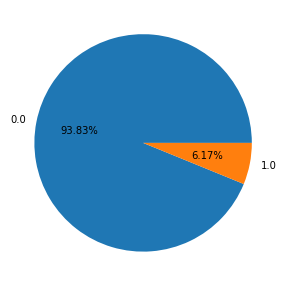

In [107]:
## Checking response variable for imbalanced data
plt.figure(figsize = (5,5))
plt.pie(df_train['future_clm_ind'].value_counts().values,labels=df_train['future_clm_ind'].value_counts().index, 
        autopct='%1.2f%%')

It does appear that the data set is heavily imbalanced. This isn't uncommon in the insurance industry, since very few people do make claims. Resampling techniques might be recommended and will be considered for the modeling.

C:\Users\JCCLI\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


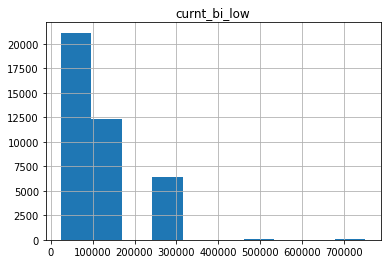

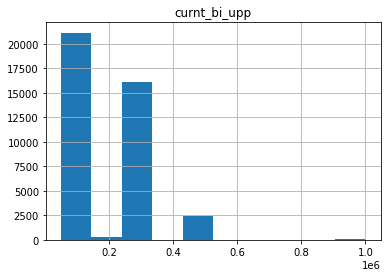

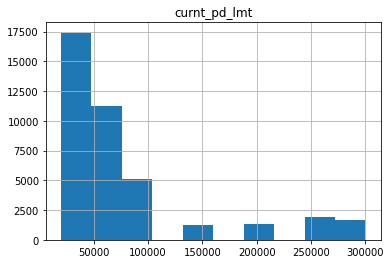

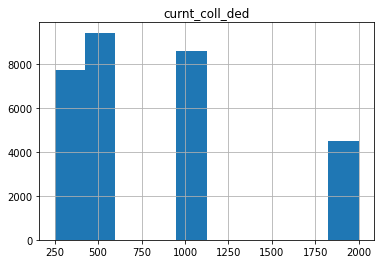

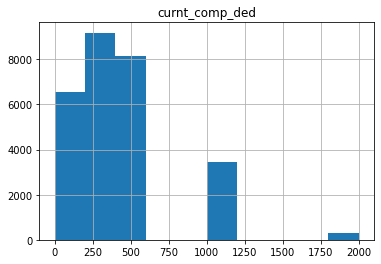

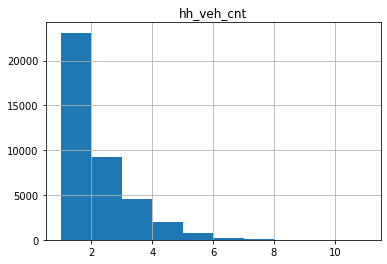

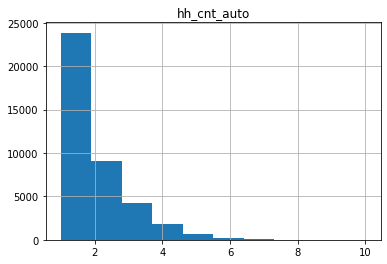

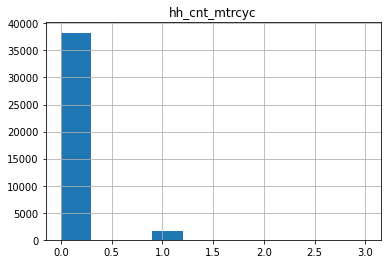

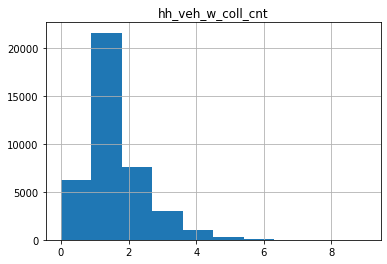

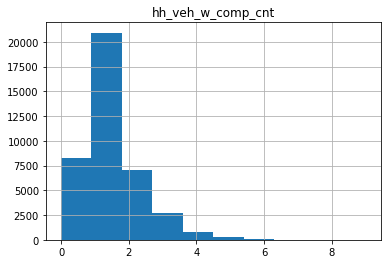

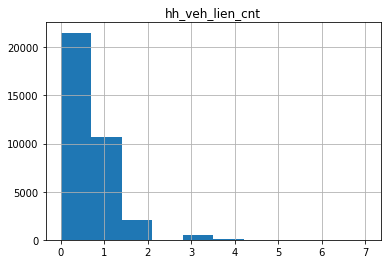

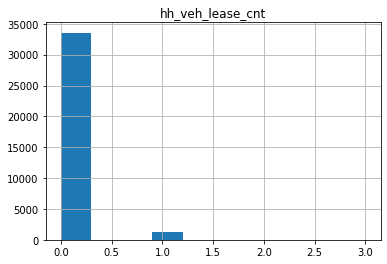

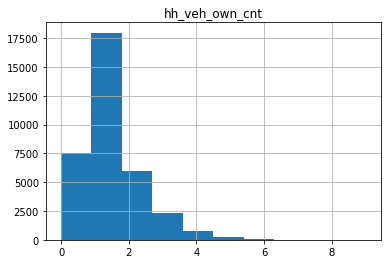

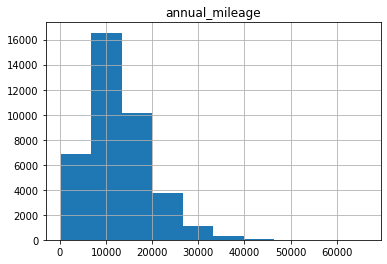

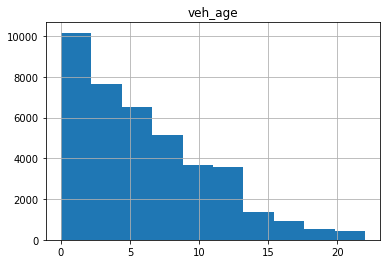

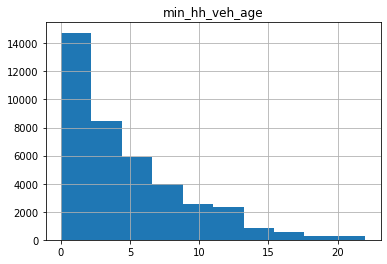

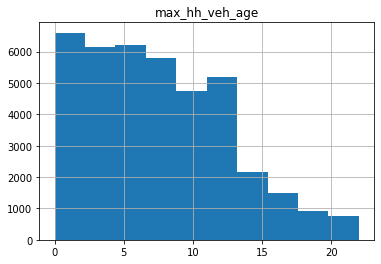

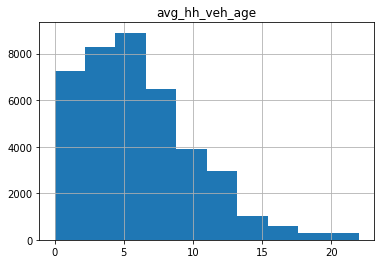

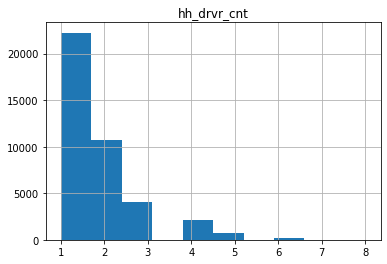

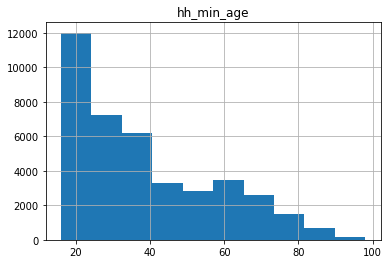

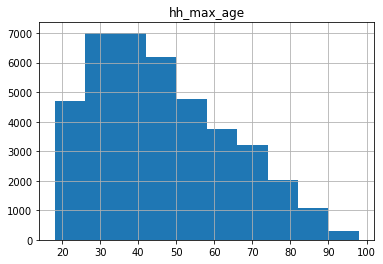

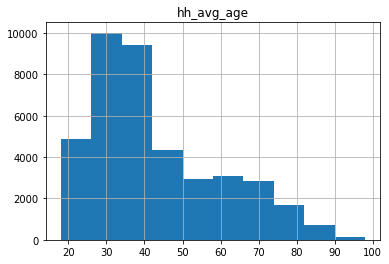

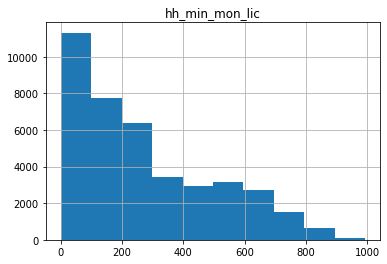

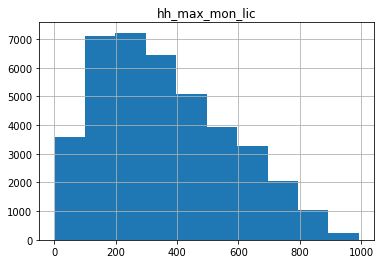

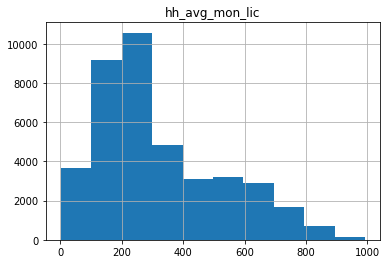

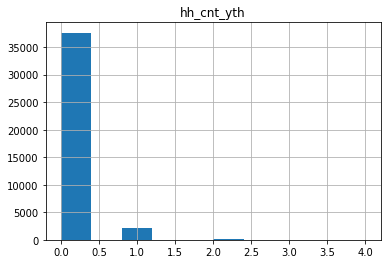

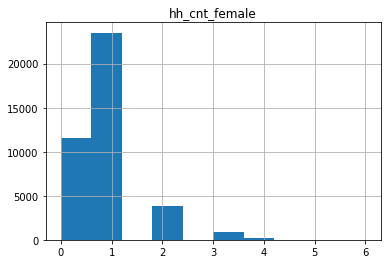

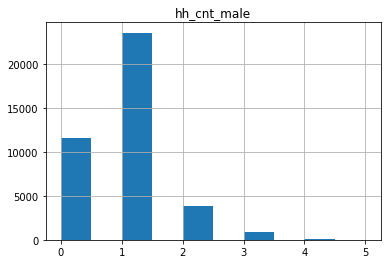

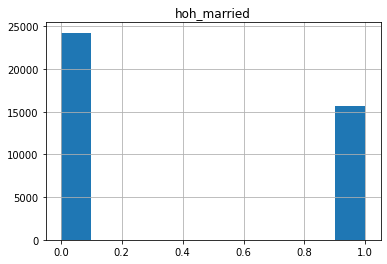

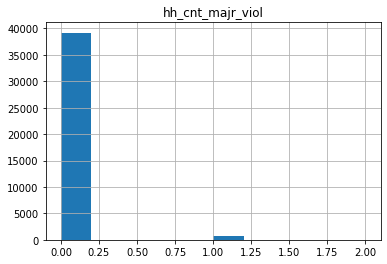

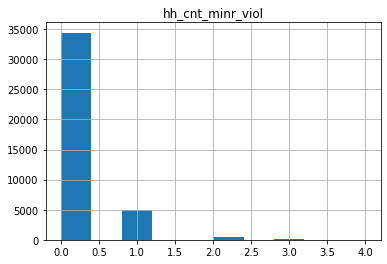

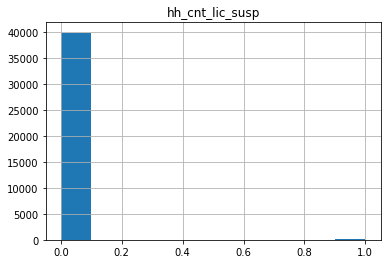

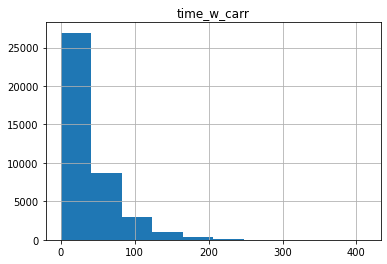

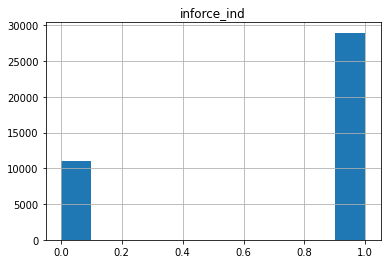

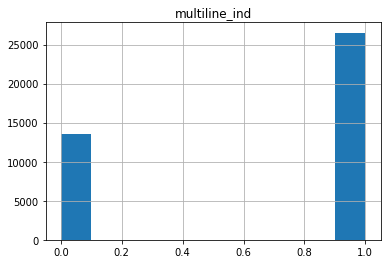

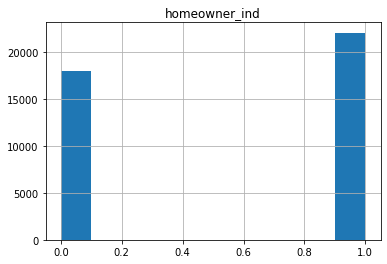

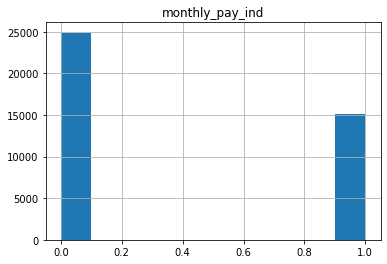

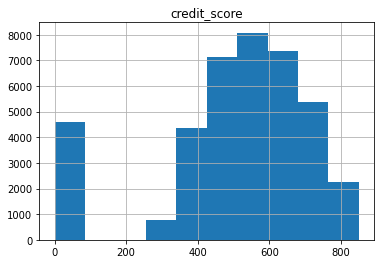

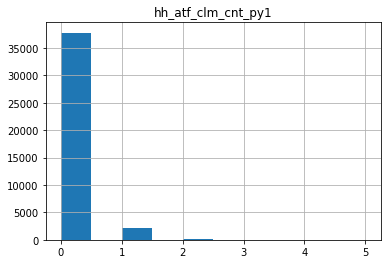

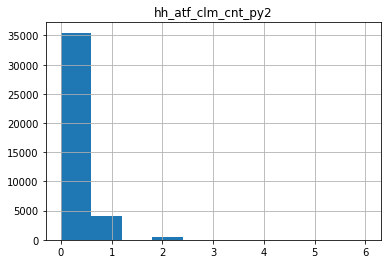

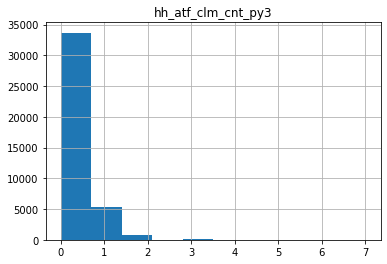

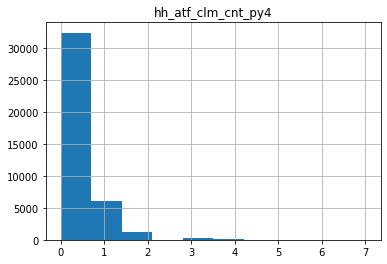

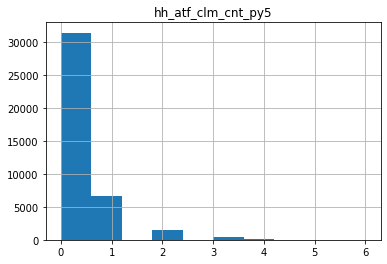

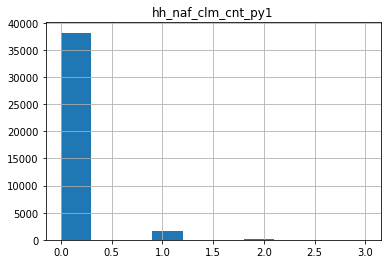

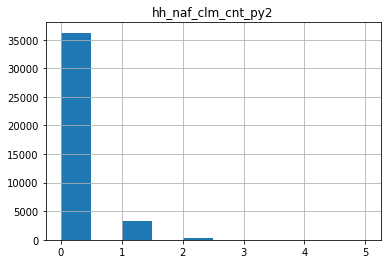

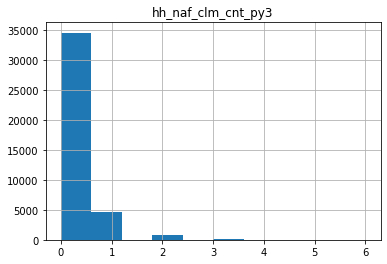

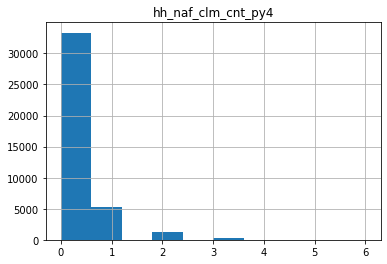

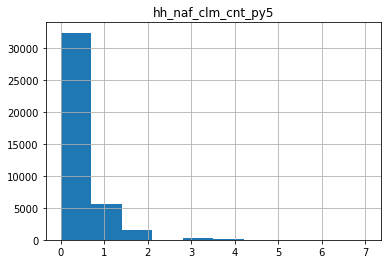

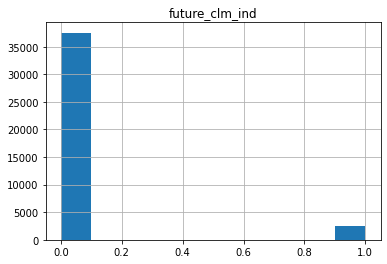

In [108]:
# Numeric Features Distribution
features = df_train.drop(['veh_ownership','veh_make','veh_model','prior_insurer','sample','plcy_id'],axis=1)

# Plot histograms of all features
for col in features.columns:      
        features[col] = pd.to_numeric(features[col]) 
        features.hist(column=col)

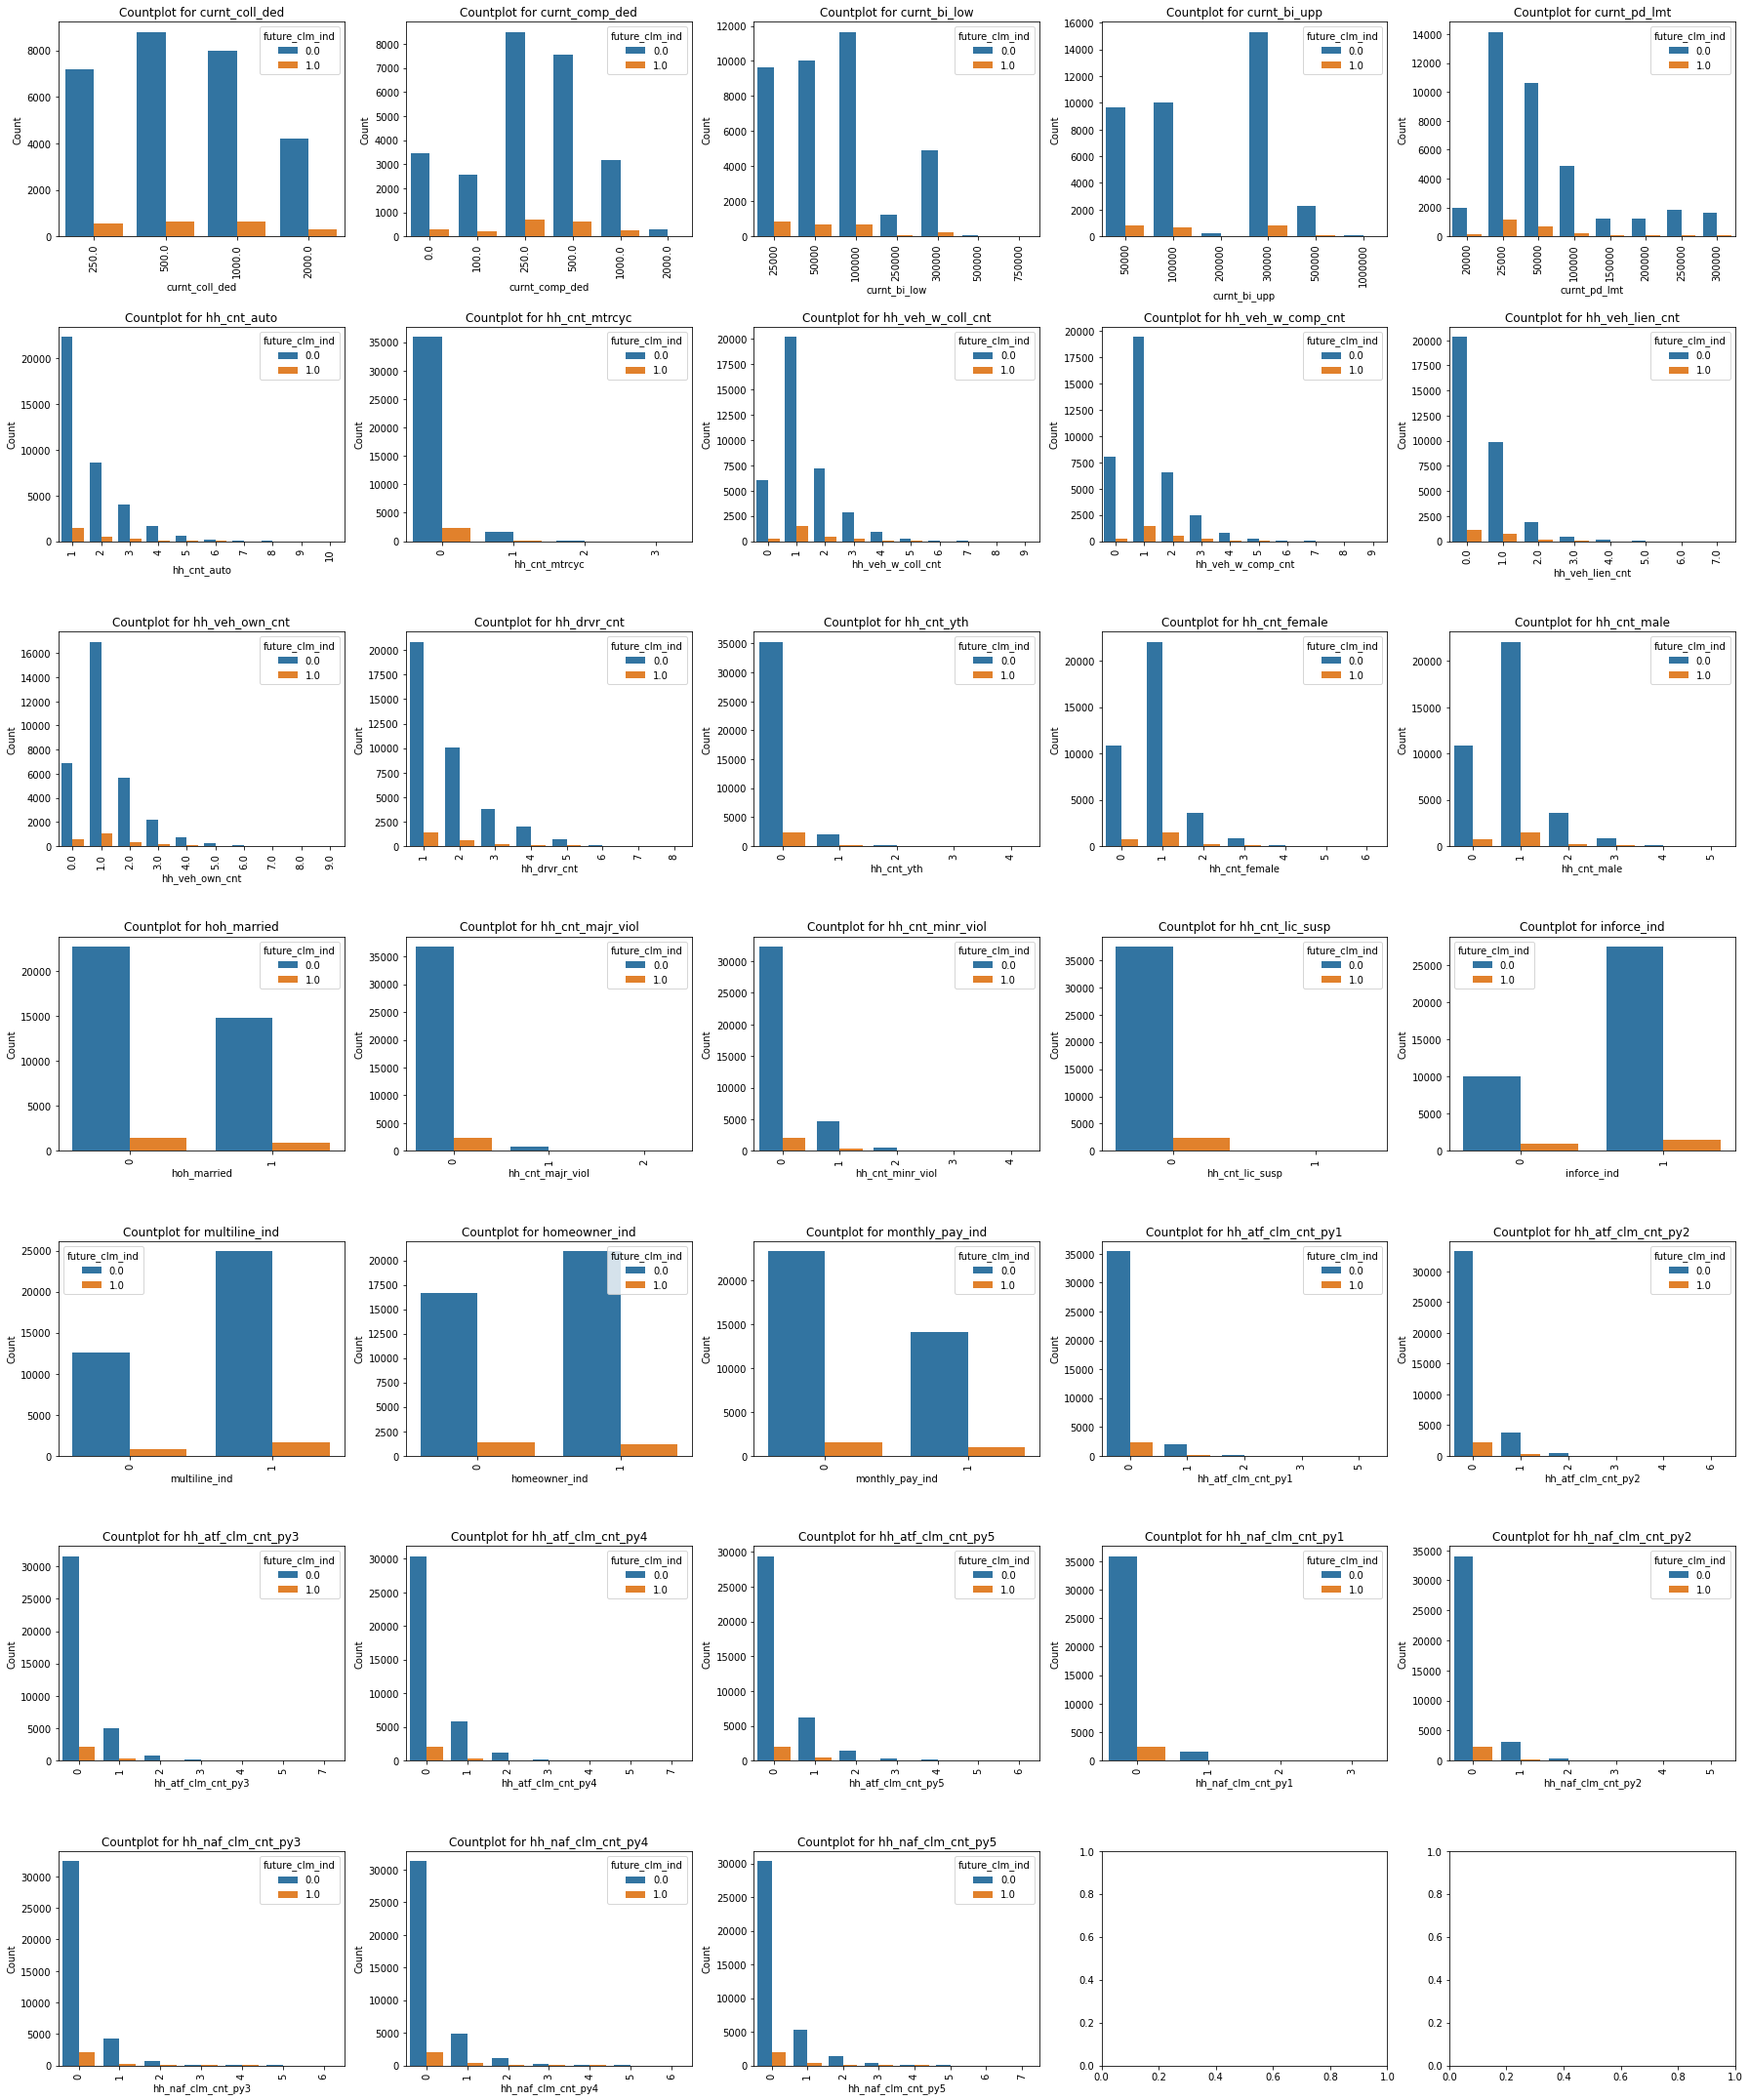

In [109]:
# Relationships with the target variable
fig, axes = plt.subplots(7,5, figsize = (25,30))
axes = axes.flatten()

cols_1 = ['curnt_coll_ded','curnt_comp_ded','curnt_bi_low','curnt_bi_upp','curnt_pd_lmt','hh_cnt_auto',\
         'hh_cnt_mtrcyc','hh_veh_w_coll_cnt','hh_veh_w_comp_cnt','hh_veh_lien_cnt','hh_veh_own_cnt','hh_drvr_cnt',\
         'hh_cnt_yth','hh_cnt_female','hh_cnt_male','hoh_married','hh_cnt_majr_viol','hh_cnt_minr_viol','hh_cnt_lic_susp',\
         'inforce_ind','multiline_ind','homeowner_ind','monthly_pay_ind','hh_atf_clm_cnt_py1','hh_atf_clm_cnt_py2',\
         'hh_atf_clm_cnt_py3','hh_atf_clm_cnt_py4','hh_atf_clm_cnt_py5','hh_naf_clm_cnt_py1','hh_naf_clm_cnt_py2',\
         'hh_naf_clm_cnt_py3','hh_naf_clm_cnt_py4','hh_naf_clm_cnt_py5']

for i, column in enumerate(cols_1):
    ax = axes[i]
    
    sns.countplot(data=df_train, x= column, ax=ax, hue = 'future_clm_ind')
    ax.set_title(f'Countplot for {column}')
    
    ax.set_ylabel('Count')
    ax.tick_params(axis='x',rotation=90)

    

plt.tight_layout()

plt.show()

<Axes: xlabel='veh_ownership', ylabel='count'>

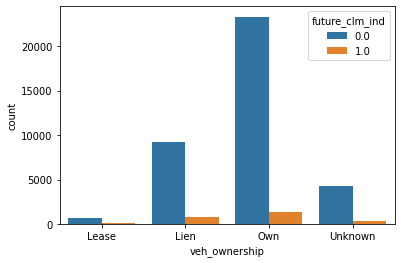

In [201]:
sns.countplot(data=df_train, x = 'veh_ownership', hue = 'future_clm_ind')

**Inferences**
- Most of our features are skewed. This is pretty common in the insurance industry. We could try using a log transformation on our independent variables since the data could most likely follow a log-normal distribution.
- The most common individual limit for Bodily Injury Coverage is 100,000.00. This is expected since it is the most recommended amount by experts.
   -  Similar for Property Damage Coverage Limit.
- Most policy holders have a credit score between 500-700.

**Relationships between target variable**
- Households who got a Collision Coverage/Comprehensive Coverage Deductible of 250.00 or 500.00 had the most claims.
- For Bodily Injury Coverage Individual Limit, most households who had a claim with the limit being around 25,000.00.
- People who were also applying for a renters policy were more likely to have a claim. It also shows that the households that own their home or more likely to have a claim.

## Preprocessing

### Data Cleaning

#### Missing Values

- There are 7 variables that have a good presence of missing data. We will use specific approaches for each variable based on their type and what is given to us in the data dictionary.
- Such methods for dealing with missing data include deletion or impution with mean, median, or separate category.
- It appears that the variables curnt_coll_ded and curnt_comp_ded have more than 20% of the data missing, while variables such as veh_ownership, hh_veh_lien_cnt, hh_veh_lease_cnt, hh_veh_own_cnt have around 12% of missing data. However, annual_mileage doesn't have as much missing data since it is less than 4%.

**curnt_coll_ded** and **curnt_comp_ded**

In [6]:
# Train
df_train['curnt_coll_ded'] = df_train['curnt_coll_ded'].replace(np.nan,-1)
df_train['curnt_coll_ded'] = df_train['curnt_coll_ded'].astype('category')

# Test
df_holdout['curnt_coll_ded'] = df_holdout['curnt_coll_ded'].replace(np.nan,-1)
df_holdout['curnt_coll_ded'] = df_holdout['curnt_coll_ded'].astype('category')

# Create new variable to replace the missing data
def Collision(x):
    if x == -1.0:
        return 'No Coverage'
    elif x == 250.0:
        return '$ 250'
    elif x == 500.0:
        return '$ 500'
    elif x == 1000.0:
        return '$ 1000'
    else:
        return '$ 2000'
df_train['curnt_coll_deductible'] = df_train['curnt_coll_ded'].apply(Collision)
df_holdout['curnt_coll_deductible'] = df_holdout['curnt_coll_ded'].apply(Collision)
df_train = df_train.drop('curnt_coll_ded',axis=1)
df_holdout = df_holdout.drop('curnt_coll_ded',axis=1)

C:\Users\JCCLI\AppData\Local\Temp\ipykernel_14804\123888683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['curnt_coll_ded'] = df_train['curnt_coll_ded'].replace(np.nan,-1)
C:\Users\JCCLI\AppData\Local\Temp\ipykernel_14804\123888683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['curnt_coll_ded'] = df_train['curnt_coll_ded'].astype('category')
C:\Users\JCCLI\AppData\Local\Temp\ipykernel_14804\123888683.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [7]:
df_train['curnt_coll_deductible'] = df_train['curnt_coll_deductible'].astype('category')
df_holdout['curnt_coll_deductible'] = df_holdout['curnt_coll_deductible'].astype('category')

In [8]:
# Comprehensive Coverage Deductible 
# Convert curnt_comp_ded to categorical
# Train
df_train['curnt_comp_ded'] = df_train['curnt_comp_ded'].replace(np.nan,-1)
df_train['curnt_comp_ded'] = df_train['curnt_comp_ded'].astype('category')

# Test
df_holdout['curnt_comp_ded'] = df_holdout['curnt_comp_ded'].replace(np.nan,-1)
df_holdout['curnt_comp_ded'] = df_holdout['curnt_comp_ded'].astype('category')

# Create new categorical variable to replace the missing data
def Comprehensive(x):
    if x == -1.0:
        return 'No Coverage'
    elif x == 0.0:
        return '$ 0'
    elif x == 250.0:
        return '$ 250'
    elif x == 500.0:
        return '$ 500'
    elif x == 1000.0:
        return '$ 1000'
    else:
        return '$ 2000'
df_train['curnt_comp_deductible'] = df_train['curnt_comp_ded'].apply(Comprehensive)
df_holdout['curnt_comp_deductible'] = df_holdout['curnt_comp_ded'].apply(Comprehensive)
df_train = df_train.drop('curnt_comp_ded',axis=1)
df_holdout = df_holdout.drop('curnt_comp_ded',axis=1)

In [9]:
df_train['curnt_comp_deductible'] = df_train['curnt_comp_deductible'].astype('category')
df_holdout['curnt_comp_deductible'] = df_train['curnt_comp_deductible'].astype('category')

**annual_mileage**

<Axes: xlabel='annual_mileage', ylabel='Count'>

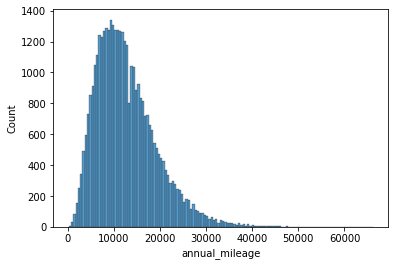

In [10]:
# Annual Mileage
# Since only 4% of the data for annual mileage is missing, we could safely impute the median

sns.histplot(df_train['annual_mileage'])

In [11]:
# Since the data looks skewed, we would want to focus on the median when imputing
df_train['annual_mileage'].median(skipna=True)

11600.0

In [12]:
df_train['annual_mileage'] = df_train['annual_mileage'].replace(np.nan,11600.0)
df_holdout['annual_mileage'] = df_holdout['annual_mileage'].replace(np.nan, 11600.0)

**veh_ownership**, **hh_veh_lien_cnt**, **hh_veh_lease_cnt**, and **hh_veh_own_cnt**

In [13]:
# Vehicle Ownership
# Replace missing value with 'Unknown'

df_train['veh_ownership'] = df_train['veh_ownership'].replace(np.nan, 'Unknown')
df_holdout['veh_ownership'] = df_holdout['veh_ownership'].replace(np.nan, 'Unknown')

In [14]:
df_train['veh_ownership'] = df_train['veh_ownership'].astype('category')
df_holdout['veh_ownership'] = df_holdout['veh_ownership'].astype('category')

In [15]:
# Train
df_train['hh_veh_lien_cnt'] = df_train['hh_veh_lien_cnt'].replace(np.nan, -1)
df_train['hh_veh_lease_cnt'] = df_train['hh_veh_lease_cnt'].replace(np.nan,-1)
df_train['hh_veh_own_cnt'] = df_train['hh_veh_own_cnt'].replace(np.nan,-1)

# Test
df_holdout['hh_veh_lien_cnt'] = df_holdout['hh_veh_lien_cnt'].replace(np.nan, -1)
df_holdout['hh_veh_lease_cnt'] = df_holdout['hh_veh_lease_cnt'].replace(np.nan,-1)
df_holdout['hh_veh_own_cnt'] = df_holdout['hh_veh_own_cnt'].replace(np.nan,-1)

In [16]:
# Train
df_train['hh_veh_lien_cnt'] = df_train['hh_veh_lien_cnt'].astype('category')
df_train['hh_veh_lease_cnt'] = df_train['hh_veh_lease_cnt'].astype('category')
df_train['hh_veh_own_cnt'] = df_train['hh_veh_own_cnt'].astype('category')

# Test
df_holdout['hh_veh_lien_cnt'] = df_holdout['hh_veh_lien_cnt'].astype('category')
df_holdout['hh_veh_lease_cnt'] = df_holdout['hh_veh_lease_cnt'].astype('category')
df_holdout['hh_veh_own_cnt'] = df_holdout['hh_veh_own_cnt'].astype('category')

**Checking for duplicates**

In [17]:
df.duplicated().value_counts()

False    60000
Name: count, dtype: int64

There are no duplicates in our dataset.

**Encode our categorical features**

In [24]:
le = preprocessing.LabelEncoder()

# Training data
for column_name in df_train.columns:
    if df_train[column_name].dtype == object or df_train[column_name].dtype == 'category':
        df_train[column_name] = le.fit_transform(df_train[column_name])
    else:
        pass

# Test data   
for column_name in df_holdout.columns:
    if df_holdout[column_name].dtype == object or df_holdout[column_name].dtype == 'category':
        df_holdout[column_name] = le.fit_transform(df_holdout[column_name])
    else:
        pass

### Feature Selection

- To get the best fit for our modeling, knowing which variables aren't as significant in predicting claims is important so we can drop them.
- To select our features, t-tests of the independent variables along with chi-square tests are our approach. Checking for Multicollinearity will also be part of the selection.
- We will drop the least important variables determined by significance tests along with highly correlated variables (Multicollinearity).
- We will look at what the top features are again after we run our model.

**T-test for significance of numeric features**

In [30]:
# Perform t-test on numeric columns
num_columns = ['hh_cnt_auto',\
         'hh_cnt_mtrcyc','hh_veh_w_coll_cnt','hh_veh_w_comp_cnt','hh_veh_lien_cnt','hh_veh_own_cnt','hh_drvr_cnt',\
         'hh_cnt_yth','hh_cnt_female','hh_cnt_male','hh_cnt_majr_viol','hh_cnt_minr_viol','hh_cnt_lic_susp',\
         'hh_atf_clm_cnt_py1','hh_atf_clm_cnt_py2',\
         'hh_atf_clm_cnt_py3','hh_atf_clm_cnt_py4','hh_atf_clm_cnt_py5','hh_naf_clm_cnt_py1','hh_naf_clm_cnt_py2',\
         'hh_naf_clm_cnt_py3','hh_naf_clm_cnt_py4','hh_naf_clm_cnt_py5','annual_mileage','veh_age','min_hh_veh_age',\
         'max_hh_veh_age','hh_min_mon_lic','hh_max_mon_lic',\
         'hh_avg_mon_lic','hh_min_age','hh_max_age','hh_avg_age','credit_score','time_w_carr', 'avg_hh_veh_age',\
              'hh_veh_lease_cnt']

for col in num_columns:
    x1=df_train.loc[(df_train.future_clm_ind==0),col]
    x2=df_train.loc[(df_train.future_clm_ind==1),col]
    _,pval=ttest_ind(x1,x2)
    print(col,pval)


hh_cnt_auto 0.5859937043376421
hh_cnt_mtrcyc 0.9960676413619225
hh_veh_w_coll_cnt 2.0096347584945672e-08
hh_veh_w_comp_cnt 1.973922223997266e-17
hh_veh_lien_cnt 0.00035329987696216945
hh_veh_own_cnt 4.814226447322966e-06
hh_drvr_cnt 0.6720219202796369
hh_cnt_yth 0.24009935511429578
hh_cnt_female 0.6987986506117732
hh_cnt_male 0.8208821605379211
hh_cnt_majr_viol 0.15294646107561347
hh_cnt_minr_viol 0.4224373693233624
hh_cnt_lic_susp 4.9780733937736516e-08
hh_atf_clm_cnt_py1 0.0075678426240609505
hh_atf_clm_cnt_py2 0.08326600199458753
hh_atf_clm_cnt_py3 0.10753485564736215
hh_atf_clm_cnt_py4 0.01645871924361347
hh_atf_clm_cnt_py5 0.00014046393769062977
hh_naf_clm_cnt_py1 0.6961005011445465
hh_naf_clm_cnt_py2 0.17124740543146827
hh_naf_clm_cnt_py3 0.06893239641680007
hh_naf_clm_cnt_py4 0.26354517262097416
hh_naf_clm_cnt_py5 0.6830522118795272
annual_mileage 8.557137504367688e-48
veh_age 7.024248982835705e-24
min_hh_veh_age 8.744358841178052e-16
max_hh_veh_age 9.914103031733383e-15
hh_min_

**The top 5 most significant independent numeric variables are:**

1. hh_avg_age

2. hh_avg_mon_lic

3. hh_max_age

4. hh_min_mon_lic

5. hh_min_age

*For a variable to be significant, the p-value needs to be less than 0.05. A lot of the most significant variables could also be highly correlated with one another, so high amounts of multicollinearity might be present.*

**Top 5 least important independent numeric variables**

1. hh_cnt_mtrcyc

2. hh_cnt_male

3. hh_naf_clm_cnt_py1

4. hh_naf_clm_cnt_py5

5. hh_drvr_cnt

*We can see that it makes sense for variables like hh_cnt_mtrcyc to be very insignificant, since not that many people own a motorcycle compared to cars.*
 

**Chi-square significance test for categorical features**

In [31]:
# Categorical Features
cat_cols = df_train.loc[:,['curnt_bi_low','curnt_bi_upp','curnt_pd_lmt','curnt_coll_deductible','curnt_comp_deductible',\
                          'multiline_ind','homeowner_ind','monthly_pay_ind','prior_insurer','veh_model','veh_make',\
                          'veh_ownership']]
f_p_values=chi2(cat_cols,df_train['future_clm_ind'])
f_p_values

(array([5.85560410e+06, 8.48009246e+06, 4.39532643e+06, 1.08179607e+02,
        1.37950898e+02, 5.82963064e-01, 4.20734969e+01, 6.05761263e-02,
        6.47973842e+00, 5.43457575e+00, 7.60935004e-01, 7.83272779e+00]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.45492642e-25,
        7.47012612e-32, 4.45153233e-01, 8.79065498e-11, 8.05587656e-01,
        1.09111040e-02, 1.97418857e-02, 3.83036074e-01, 5.13086101e-03]))

In [32]:
p_chi=pd.Series(f_p_values[1])
p_chi.index=cat_cols.columns
p_chi.sort_values(ascending=True)[p_chi.sort_values(ascending=True)<0.05].index

Index(['curnt_bi_low', 'curnt_bi_upp', 'curnt_pd_lmt', 'curnt_comp_deductible',
       'curnt_coll_deductible', 'homeowner_ind', 'veh_ownership',
       'prior_insurer', 'veh_model'],
      dtype='object')

<Axes: >

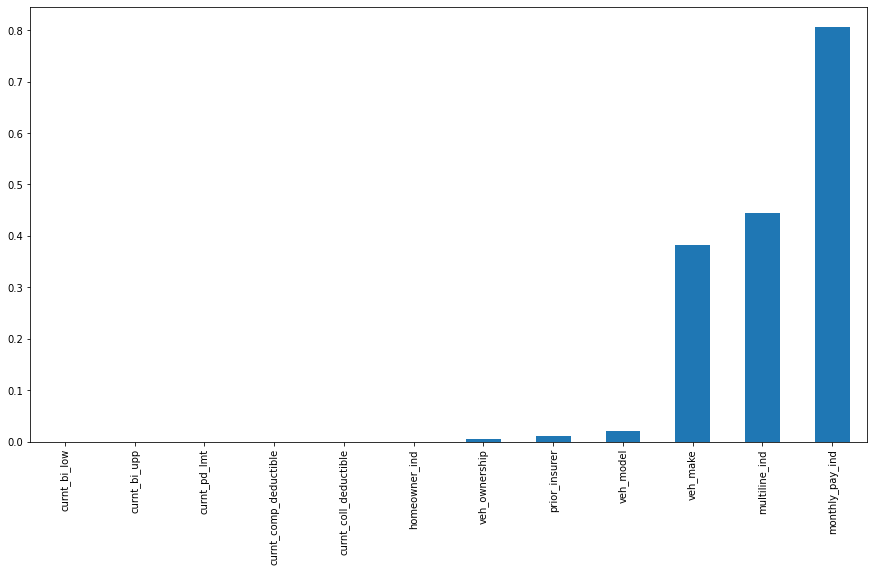

In [33]:
plt.figure(figsize=(15,8))
p_chi.sort_values(ascending=True).plot(kind='bar')

**Checking for multicollinearity**

One of the assumptions of linear and logistic regression is that the features are independent of one another. Multicollinearity violates this assumption, so we need to check for it and find ways to handle it if possible. Let's check the VIF for the independent variables

In [34]:
X = df_train[['hh_cnt_auto',\
         'hh_cnt_mtrcyc','hh_veh_w_coll_cnt','hh_veh_w_comp_cnt','hh_veh_lien_cnt','hh_veh_own_cnt','hh_drvr_cnt',\
         'hh_cnt_yth','hh_cnt_female','hh_cnt_male','hh_cnt_majr_viol','hh_cnt_minr_viol','hh_cnt_lic_susp',\
         'hh_atf_clm_cnt_py1','hh_atf_clm_cnt_py2',\
         'hh_atf_clm_cnt_py3','hh_atf_clm_cnt_py4','hh_atf_clm_cnt_py5','hh_naf_clm_cnt_py1','hh_naf_clm_cnt_py2',\
         'hh_naf_clm_cnt_py3','hh_naf_clm_cnt_py4','hh_naf_clm_cnt_py5','annual_mileage','veh_age','min_hh_veh_age',\
         'max_hh_veh_age','hh_min_mon_lic','hh_max_mon_lic',\
         'hh_avg_mon_lic','hh_min_age','hh_max_age','hh_avg_age','credit_score','time_w_carr','avg_hh_veh_age',\
             'hh_veh_lease_cnt']]

# Check VIFs
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                  for i in range(len(X.columns))]

C:\Users\JCCLI\miniconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [35]:
print(vif_data)

               feature           VIF
0          hh_cnt_auto  2.494213e+01
1        hh_cnt_mtrcyc  1.324014e+00
2    hh_veh_w_coll_cnt  1.732155e+01
3    hh_veh_w_comp_cnt  1.397741e+01
4      hh_veh_lien_cnt  6.663206e+00
5       hh_veh_own_cnt  1.045211e+01
6          hh_drvr_cnt           inf
7           hh_cnt_yth  1.519089e+00
8        hh_cnt_female           inf
9          hh_cnt_male           inf
10    hh_cnt_majr_viol  1.133492e+00
11    hh_cnt_minr_viol  1.264220e+00
12     hh_cnt_lic_susp  1.081510e+00
13  hh_atf_clm_cnt_py1  1.892631e+00
14  hh_atf_clm_cnt_py2  3.884598e+00
15  hh_atf_clm_cnt_py3  6.049008e+00
16  hh_atf_clm_cnt_py4  7.879113e+00
17  hh_atf_clm_cnt_py5  5.137365e+00
18  hh_naf_clm_cnt_py1  1.913066e+00
19  hh_naf_clm_cnt_py2  3.950894e+00
20  hh_naf_clm_cnt_py3  6.180726e+00
21  hh_naf_clm_cnt_py4  8.295698e+00
22  hh_naf_clm_cnt_py5  5.445124e+00
23      annual_mileage  4.964889e+00
24             veh_age  1.123445e+01
25      min_hh_veh_age  7.695294e+01
2

It appears that a lot of our variables are extremely correlated, causing a lot of multicollinearity in the model. The values we got in our significance test do show evidence here that they are all related to one another causing this. The top variables where this is the case are:

1. hh_cnt_male

2. hh_cnt_female

3. hh_drvr_cnt

4. hh_min_mon_lic

5. hh_max_mon_lic

6. hh_avg_mon_lic

7. hh_min_age

8. hh_max_age

9. hh_avg_age


Other variables have strong correlation as well, but they are also variables that seem more important for the prediction so our goal is to find a way to handle some of the multicollinearity while still being able to keep some features since our data is highly correlated.

Some ways we can handle multicollinearity include:

- **Use dimensionality reduction techniques (PCA)**

- **Remove the highly correlated features**

- **Perform regularization techniques such as Lasso or Ridge Regression**


The 2nd and 3rd one feel like the best options since we have a huge amount of features so we don't need to keep all of them and if we perform regularization techniques we will be able to deal more with the collinearity while retaining our columns we want to keep that are highly correlated. 

**Adding new indicator variables to our model**

**Drivers under 18**

While some of the features were highly correlated, some of them were still worth including in the model, such as number of male/female drivers. One important thing to note is male drivers under the age of 18 are the most expensive to insure because they have the most violations and automobile accidents. A new indicator variable 'is_male_yth' indicates whether they have a male driver under 18. I also added one for female drivers under 18 as well.

In [25]:
# Males under 18
df_train['is_male_yth'] = np.where((df_train['hh_cnt_male']>0) & (df_train['hh_cnt_yth']>0),1,0)
df_holdout['is_male_yth'] = np.where((df_holdout['hh_cnt_male']>0) & (df_holdout['hh_cnt_yth']>0),1,0)

In [26]:
# Females under 18
df_train['is_female_yth'] = np.where((df_train['hh_cnt_female']>0) & (df_train['hh_cnt_yth']>0),1,0)
df_holdout['is_female_yth'] = np.where((df_holdout['hh_cnt_female']>0) & (df_holdout['hh_cnt_yth']>0),1,0)

**People who are insured and own the home vs people who have Renters policy**

From my knowledge, someone that owns their home and insures it usually has lower rates. Someone that only has autos insured or someone who has Renters policy is worse off. A new interaction indicator variable indicating whether someone is insured prior to State Farm and also owns a home or not will be created. If they don't own the home than they presumably have Renters policy.

In [27]:
df_train['ins_own'] = np.where((df_train['inforce_ind']==1) & (df_train['homeowner_ind']==1),1,0)
df_holdout['ins_own'] = np.where((df_holdout['inforce_ind']==1) & (df_holdout['homeowner_ind']==1),1,0)

**Dropping features from our model**

In [28]:
# We definitely won't use the variables 'plcy_id' or 'sample' in our model, so we can delete them for now.
# We could also delete the most insignificant features from our dataset too
df_train_dropped = df_train.drop(['hh_cnt_mtrcyc','hh_naf_clm_cnt_py1','hh_naf_clm_cnt_py2',\
                                  'hh_drvr_cnt','veh_make','monthly_pay_ind',\
                                  'hh_naf_clm_cnt_py3','hh_naf_clm_cnt_py4','hh_veh_lease_cnt','hh_cnt_female',\
                                  'min_hh_veh_age','max_hh_veh_age','hh_min_mon_lic','hh_max_mon_lic',\
                                  'hh_atf_clm_cnt_py1','hh_atf_clm_cnt_py2','hh_atf_clm_cnt_py3',\
                                 'hh_atf_clm_cnt_py4'],axis=1)


df_holdout_dropped = df_holdout.drop(['hh_cnt_mtrcyc','hh_naf_clm_cnt_py1','hh_naf_clm_cnt_py2','hh_naf_clm_cnt_py3',\
                                     'hh_naf_clm_cnt_py4','hh_drvr_cnt','veh_make','monthly_pay_ind',\
                                     'hh_veh_lease_cnt','hh_cnt_female','min_hh_veh_age',\
                                     'max_hh_veh_age','hh_min_mon_lic','hh_max_mon_lic',\
                                     'hh_atf_clm_cnt_py1','hh_atf_clm_cnt_py2','hh_atf_clm_cnt_py3',\
                                 'hh_atf_clm_cnt_py4'],axis=1)

#### Dealing with imbalanced classes for predictor variable

It appears that our predictor variable, "future_clm_ind" is very imbalanced due to it not being common for holders to make a claim. To be able to get the most accurate model for this data, it can be recommended to use oversampling/undersampling techniques. We will use oversampling techniques here since our dataset isn't too big and we want to be able to retain our information by oversampling our minority class. 

In [29]:
x = df_train_dropped.drop(['future_clm_ind','sample'],axis=1)
y = df_train_dropped['future_clm_ind']

In [30]:
# Apply SMOTE oversampling
smt =  SMOTE(random_state=12,sampling_strategy = 0.3)

x, y =  smt.fit_resample(x,y)

x.shape, y.shape

((48791, 38), (48791,))

In [31]:
# Append results to new training data set
df_train_final = pd.concat([x,y],axis=1)

In [32]:
X_train = df_train_final.drop(['future_clm_ind','plcy_id'],axis=1)
Y_train = df_train_final['future_clm_ind']

X_test = df_holdout_dropped.drop(['future_clm_ind','plcy_id','sample'],axis=1)

**Fit model**

Since the target variable contains missing data for the test (holdout) data set, this means that we don't have actual values to compare with the predicted values, since our test data is meant to be unseen. We will instead, for validation purposes, split up our training data into two parts, just for this one part, to test the accuracy of our model.

In [33]:
# Fit a logistic regression model while applying regularization techniques (Lasso) to optimize it for the high collinearity
LR_model = LogisticRegression(penalty = 'l1', solver = 'liblinear')

# Fit the logistic regression model on the training data
LR_model.fit(X_train, Y_train)

# Make predictions on the testing data
y_pred = LR_model.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(Y_train, y_pred)
print("Accuracy:", accuracy)

classification_rep = classification_report(Y_train, y_pred)
print("Classification Report:\n", classification_rep)

Accuracy: 0.8503617470435121
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     37532
         1.0       0.75      0.53      0.62     11259

    accuracy                           0.85     48791
   macro avg       0.81      0.74      0.76     48791
weighted avg       0.84      0.85      0.84     48791



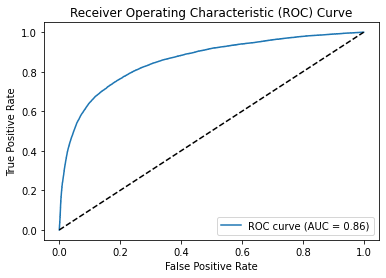

In [166]:
# Get the predicted probabilities for the positive class
y_pred_proba = LR_model.predict_proba(X_train)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(Y_train, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(Y_train, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [173]:
# Get the predicted probabilities for the positive class
y_pred_proba = LR_model.predict_proba(X_train)[:, 1]

precision, recall, _= precision_recall_curve(Y_train,y_pred_proba)

# Calculate the area under the precision-recall curve (PR-AUC)
pr_auc = metrics.auc(recall, precision)

print("PR-AUC Score:", pr_auc)


PR-AUC Score: 0.6949987345807398


<Axes: ylabel='Feature'>

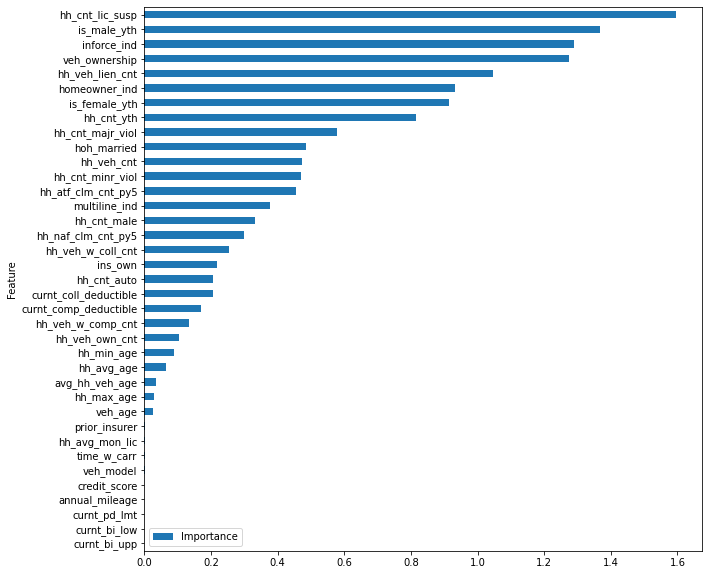

In [167]:
# Feature Importance
coefficients = LR_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x="Feature", y='Importance', kind='barh', figsize = (10,10))

**Most important features in predicting whether someone made a claim**

The top 3 most important variables in predicting claims here include the count of male drivers under 18, whether they were insured prior to coming to State Farm, and what type of vehicle ownership the household has. These can be pretty accurate variables in determining claims, since males under 18 can get into the most accidents, which can make getting a claim more likely.

**Setting up a validation set**

The final thing we want to check with the model is how well it could perform on unseen data. So we will use the training data to split it up into another training set and a validation set to test the performance. Note we will need to use SMOTE again after splitting the data up to reduce bias/avoid data leakage.

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=41)

In [35]:
# Apply SMOTE
smt =  SMOTE(random_state=12,sampling_strategy = 0.3)

x_train, y_train =  smt.fit_resample(x_train,y_train)

x_train.shape, y_train.shape

((39109, 38), (39109,))

In [36]:
# Fit a logistic regression model while applying regularization techniques (Lasso)
LR_model_val = LogisticRegression(penalty = 'l1', solver = 'liblinear')

# Fit the logistic regression model on the training data
LR_model_val.fit(x_test, y_test)

# Make predictions on the testing data
y_pred = LR_model_val.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Accuracy: 0.8455784404139769
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.95      0.90      7448
         1.0       0.75      0.52      0.61      2311

    accuracy                           0.85      9759
   macro avg       0.81      0.73      0.76      9759
weighted avg       0.84      0.85      0.84      9759



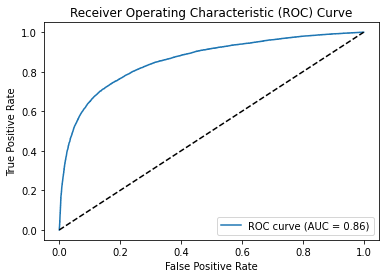

In [137]:
# Get the predicted probabilities for the positive class
y_pred_proba_val = LR_model_val.predict_proba(x_train)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_val)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_train, y_pred_proba_val)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

While it does look like our model did underfit a little, the accuracies are still almost the same at 0.85, so this shows evidence that our model can perform well on unseen data, by applying SMOTE after splitting the training and validation set.

**Obtain predicted probabilities of future_clm_ind = 1**

In [175]:
# Train
y_pred_train = LR_model.predict_proba(X_train)[:,1]


print(y_pred_train)

[0.03691002 0.07656489 0.12412702 ... 0.8444773  0.49054202 0.72725786]


In [176]:
y_pred_test = LR_model.predict_proba(X_test)[:,1]
print(y_pred_test)

[0.28363412 0.17057034 0.14472764 ... 0.04841542 0.05918858 0.06085669]


### Add results to csv file

In [177]:
# Create a new variable glmpred of the predicted results from the model for both the training and test sets
train_pred = pd.DataFrame({"plcy_id" : df_train_final["plcy_id"], "glm_pred" : y_pred_train})
train_pred

,plcy_id,glm_pred
0,1,0.036910
1,2,0.076565
2,3,0.124127
3,4,0.366970
4,5,0.082100
...,...,...
48786,5580,0.104604
48787,19446,0.374689
48788,24774,0.844477
48789,15982,0.490542


In [178]:
# Ignore oversampled classes that were used in the model development
train_pred_fin = train_pred.loc[0:39999]

In [179]:
test_pred =  pd.DataFrame({"plcy_id" : df["plcy_id"][df["sample"] == "Holdout"], "glm_pred" : y_pred_test})
test_pred

,plcy_id,glm_pred
40000,40001,0.283634
40001,40002,0.170570
40002,40003,0.144728
40003,40004,0.087119
40004,40005,0.359046
...,...,...
59995,59996,0.221316
59996,59997,0.091982
59997,59998,0.048415
59998,59999,0.059189


In [180]:
# Add 2 dataframes together
glmresults = pd.concat([train_pred_fin,test_pred],axis=0)

# Create CSV file 'glmresults.csv'
glmresults.to_csv("C://Users//JCCLI//Downloads//DS_Work_Sample_Scored.csv",index=False,header=True)